In [113]:
from keras.layers import Dropout,Dense, TimeDistributed,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import librosa
from librosa.core import resample, to_mono
from python_speech_features import mfcc, logfbank
import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras

In [104]:
path = 'freesound-audio-tagging/'

data_train =pd.read_csv(path+'/training_new.csv')
data_test =pd.read_csv(path+'/testing_new.csv')
print(data_train,'\n',data_test)

            fname    label  manually_verified
0    002d256b.wav  Trumpet                  0
1    034e4ffa.wav  Trumpet                  0
2    03e13ae7.wav  Trumpet                  0
3    04335030.wav  Trumpet                  0
4    04490642.wav  Trumpet                  0
..            ...      ...                ...
505  147f4395.wav    Cello                  0
506  14fd19da.wav    Cello                  0
507  154df401.wav    Cello                  1
508  161be325.wav    Cello                  0
509  188acf6a.wav    Cello                  1

[510 rows x 3 columns] 
            fname    label  manually_verified
0   16d7ab94.wav  Trumpet                  1
1   17cbf99c.wav  Trumpet                  0
2   180cd1d7.wav  Trumpet                  1
3   1902bf23.wav  Trumpet                  0
4   1a13793b.wav  Trumpet                  0
..           ...      ...                ...
80  18c3695b.wav    Cello                  0
81  195f544d.wav    Cello                  1
82  199b1adf.wav 

In [105]:
NCLASS = data_train['label'].nunique()
#create a column with the audio length
df = data_train.set_index('fname')
print(df)
for f in df.index:
    rate, signal = wavfile.read(path+'clean/'+f)
    df.at[f,'length'] = signal.shape[0]/rate

#associste each class with the mean audio length of its entries
classes = list(np.unique(data_train.label))
classes_dist = df.groupby(['label'])['length'].mean()

print(df,'\n',classes_dist,'\nNCLASS: ',NCLASS)

                label  manually_verified
fname                                   
002d256b.wav  Trumpet                  0
034e4ffa.wav  Trumpet                  0
03e13ae7.wav  Trumpet                  0
04335030.wav  Trumpet                  0
04490642.wav  Trumpet                  0
...               ...                ...
147f4395.wav    Cello                  0
14fd19da.wav    Cello                  0
154df401.wav    Cello                  1
161be325.wav    Cello                  0
188acf6a.wav    Cello                  1

[510 rows x 2 columns]
                label  manually_verified     length
fname                                              
002d256b.wav  Trumpet                  0   0.233250
034e4ffa.wav  Trumpet                  0   3.326375
03e13ae7.wav  Trumpet                  0   5.787687
04335030.wav  Trumpet                  0   0.698562
04490642.wav  Trumpet                  0  23.600000
...               ...                ...        ...
147f4395.wav    Cello      

In [114]:
#shuffle classes
def build_rand_feat():
    X =[]
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(classes_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate, wav = wavfile.read(path+'clean/'+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index : rand_index+config.step]
        #get mel features 
        X_sample = mfcc(sample,rate,numcep=config.nfeat, nfilt = config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    X,y = np.array(X), np.array(y)
    X = (X-_min)/(_max-_min)  #normalize
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    y = to_categorical(y,num_classes = NCLASS)
    return X,y

#
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(6, (2, 2),strides=(1,1), padding='valid', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (2, 2),strides=(1,1), padding='valid', activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(NCLASS, activation='softmax'))
    opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

class Config:
    def __init__(self, nfilt=26,nfeat =13,nfft=512,rate = 16000):
        self.nfilt = nfilt
        self.nfeat = nfeat 
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

### Run Classical CNN model on the mel spectrogram

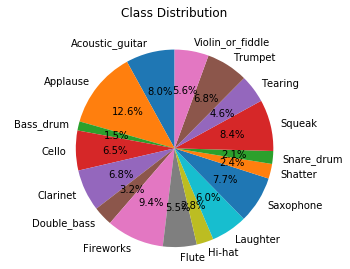

100%|██████████| 62276/62276 [02:51<00:00, 363.46it/s]


In [108]:
n_samples = 2*int(df['length'].sum()/0.1)
prob_dist = classes_dist / classes_dist.sum()
choices = np.random.choice(classes_dist.index,p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution',y= 1.08)
ax.pie(classes_dist,labels=classes_dist.index,autopct='%1.1f%%',shadow = False, startangle=90)
ax.axis('equal')
plt.show()

config = Config()
X,y = build_rand_feat()


In [115]:
y_flat = np.argmax(y,axis=1)
input_shape=(X.shape[1],X.shape[2],1)
model = get_conv_model()
class_weight = compute_class_weight('balanced',np.unique(y_flat),y_flat)
class_weight = {i : class_weight[i] for i in range((NCLASS))}
model.fit(X,y,epochs =10,batch_size=5,shuffle=True,class_weight = class_weight)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], y=[ 1 14 16 ...  0 15 15] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/10
12456/12456 [==============================] - 21s 2ms/step - loss: 2.8459 - accuracy: 0.0440
Epoch 2/10
12456/12456 [==============================] - 18s 1ms/step - loss: 2.8455 - accuracy: 0.0404
Epoch 3/10
12456/12456 [==============================] - 17s 1ms/step - loss: 2.8460 - accuracy: 0.0422
Epoch 4/10
12456/12456 [==============================] - 17s 1ms/step - loss: 2.8458 - accuracy: 0.0427
Epoch 5/10
12456/12456 [==============================] - 16s 1ms/step - loss: 2.8454 - accuracy: 0.0437
Epoch 6/10
12456/12456 [==============================] - 18s 1ms/step - loss: 2.8460 - accuracy: 0.0422
Epoch 7/10
12456/12456 [==============================] - 19s 1ms/step - loss: 2.8449 - accuracy: 0.0430
Epoch 8/10
12456/12456 [==============================] - 17s 1ms/step - loss: 2.8455 - accuracy: 0.0413
Epoch 9/10
12456/12456 [==============================] - 18s 1ms/step - loss: 2.8449 - accuracy: 0.0405
Epoch 10/10
12456/12456 [==============================

### Quantum Preprocessing (applying the circuit on the mel spectrogram)

In [149]:
n_epochs = 10   # Number of optimization epochs
n_layers = 2    # Number of random layers
n_train = len(X)    # Size of the train dataset
n_test = 30     # Size of the test dataset
print(X[0].shape)
SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

(13, 9, 1)


In [ ]:
#tf model
def Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(NCLASS, activation='softmax'))
    opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

out_height= int(((X[0].shape[0] - 2)/2)+1)
out_width  = int(((X[0].shape[1] -2)/2)+1)
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""

    out = np.zeros((out_height,out_width, 4))
    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, X[0].shape[0]-1, 2):
        for k in range(0, X[0].shape[1]-1, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                print(j//2, k//2, c)
                out[j // 2, k // 2, c] = q_results[c]
    return out


if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(X):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

#     q_test_images = []
#     print("\nQuantum pre-processing of test images:")
#     for idx, img in enumerate(test_images):
#         print("{}/{}        ".format(idx + 1, n_test), end="\r")
#         q_test_images.append(quanv(img))
#     q_test_images = np.asarray(q_test_images)



In [ ]:
### Run Quanvolutional Neural Network model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y,
    batch_size=5,
    epochs=10,
    shuffle=True,
    class_weight = class_weight
    verbose=2,
)
